# Чат бот во с клавиатурой во ВКонтакте в группе для абитуриентов института ЭМИТ Отделения экономики

## Токены, файлы, подгрузка и импортирование библиотек, авторизация, запуск сессии

In [2]:
# !pip install requests
# !pip install beautifulsoup4
# !pip install vk_api

In [3]:
import vk_api
from vk_api.longpoll import VkLongPoll, VkEventType
from vk_api.utils import get_random_id
from vk_api import VkUpload
from vk_api.keyboard import VkKeyboard, VkKeyboardColor

import pandas as pd
import numpy as np
from IPython.display import display, clear_output

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

In [4]:
authorize = vk_api.VkApi(token = group_token)
vk_session = vk_api.VkApi(token=my_token)
s = vk_session.get_api()

In [5]:
longpoll = VkLongPoll(authorize)
upload = VkUpload(authorize)

## Функции отправки сообщения без клавиатуры и с клавиатурой

In [6]:
def write_only_message(sender, message):
    authorize.method('messages.send', 
                     {'user_id':sender, 'message':message, 'random_id':get_random_id()})

In [7]:
def write_message(sender, message, attachment):
    authorize.method('messages.send', 
                     {'user_id':sender, 'message':message, 'random_id':get_random_id(), 'attachment':attachment})

In [8]:
def write_only_message_keyboard(sender, message, keyboard):
    authorize.method('messages.send', 
                     {'user_id':sender, 'message':message, 'random_id':get_random_id(), 'keyboard':keyboard.get_keyboard()}
                    )

In [9]:
def write_message_keyboard(sender, message, photo, keyboard):
    authorize.method('messages.send', 
                     {'user_id':sender, 'message':message, 'random_id':get_random_id(), 'attachment':photo, 'keyboard':keyboard.get_keyboard()}
                    )

## Фукнция добавления групп пользователя в список

In [10]:
def group_list(sender):
    user_groups = []
    try:
        groups_info = s.groups.get(user_id = sender, extended=1)
#         print(groups_info)
        for j in range(groups_info['count']):
            user_groups.append(groups_info['items'][j]['name'])
        return(user_groups)
    except:
        user_groups.append(None)
        return(list_groups)

## Функция получения данных о пользователе

In [11]:
def info(sender):
    result = s.users.get(user_ids = sender, fields = ['schools', 'city', 'bdate'])
    
    
    try: 
        school = result[0]['schools'][0]['name']
    except:
        school = None
        
    try: 
        city = result[0]['city']['title']
    except:
        city = None
       
    
    try: 
        first_name = result[0]['first_name']
        last_name = result[0]['last_name']
        full_name = first_name + ' ' + last_name
    except:
        full_name = None
        
        
    try: 
        bdate = datetime.strptime(result[0]['bdate'], '%d.%m.%Y')
        day = bdate.day
        month = bdate.month
        year = bdate.year
    except:
        year = None
        try: 
            bdate = datetime.strptime(result[0]['bdate'], '%d.%m')
            day = bdate.day
            month = bdate.month
        except:
            day = None
            month = None
            
    return(school, city, full_name, day, month, year)

## Фукнция Scrapping'а и обработки таблицы поступающих с сайта ранхигс
Шаги обработки указаны в комментариях к коду

In [12]:
old = 1324

In [13]:
def get_parsing_data():
    global old
    # Запрос к сайту
    url = "https://lk.ranepa.ru/online/pk/list/list.php?FT=1&FL=0&FK=&FC=&FB=&FO=&F1=3dfc1680-5eff-4887-a318-288990d0e055&F2=66fef4e2-c613-11e5-80e4-005056a00b6e&F3=2e1647b4-ed90-11ed-a2e5-149ecf4cb24c&F4=32e2ec09-5ac0-11ed-a2df-149ecf4cb249"
    response = requests.get(url)

    # Парсинг HTML страницы
    soup = BeautifulSoup(response.content, 'html.parser')

    # Поиск класса с таблицей в HTML
    element = soup.find(class_="ranepa-table withrot270x entrants")

    # Получение списка колонок
    headers = [th.text.strip().replace('\xa0',' ') for th in element.find_all('th')]

    # Получение данных
    data = []
    rows = element.find_all('tr')
    for row in rows:
        row_data = [td.text.strip() for td in row.find_all('td')]
    #     print(row_data)
        if row_data:  # Пропускаю пустые строки(например 0)
            data.append(row_data)

    # Создание датафрейма
    balls = pd.DataFrame(data, columns=headers)
    balls = balls.dropna().copy()
    
    # Коверирование str колонок к числовому формату
    columns_to_convert = [
    'Сумма баллов по индивидуальным достижениям',
    'математика',
    'информатика иИКТ (по выбору)',
    'обществознание (по выбору)',
    'русский язык',
    'Приоритет зачисления'
    ]

    balls[columns_to_convert] = balls[columns_to_convert].apply(pd.to_numeric, errors='coerce')

    # Создание колонки с суммой баллов за ЕГЭ + ИД
    balls['сумма'] = (
        balls['Сумма баллов по индивидуальным достижениям']
        + balls['математика']
        + np.maximum(balls['информатика иИКТ (по выбору)'], balls['обществознание (по выбору)'])
        + balls['русский язык']
    )
    
    # Очистка от выбросов, где данные ЕГЭ ещё не прогрузились. Т.е. сумма баллов не более 10.
    balls = balls[balls['сумма']>10].copy().reset_index(drop=True)
    
    # Количество поданных заявлений при прошлом обновлении и текущем. Их разница
    new = len(balls)
    quantity = new - old
    old = new
    
    
    # Сохранение таблицы в xlsx формате
    balls.to_excel('balls.xlsx', index=False)
    
    return(balls, quantity)


In [14]:
result = get_parsing_data()
balls = result[0]
dif_quantity = result[1]

### Полученная таблица

In [15]:
balls

,№,СНИЛС / ID,Номер дела,Сумма баллов по индивидуальным достижениям,математика,информатика иИКТ (по выбору),обществознание (по выбору),русский язык,Приоритет зачисления,Примечание (документ об образовании),сумма
0,1,04564926043,000011/ОТК,0,68,0,83,97,11,Копия,248
1,2,04815083510,000004/ОТК,5,76,0,90,91,4,Копия,262
2,3,06616013645,000094/ОТК,3,64,0,63,83,5,Копия,213
3,5,10384463085,000063/ОТК,5,76,0,92,87,14,Копия,260
4,6,12205777368,000055/ОТК,0,66,0,72,73,1,Копия,211
...,...,...,...,...,...,...,...,...,...,...,...
1319,1335,14090659657,001748,10,82,0,81,100,1,Копия,273
1320,1336,19089275112,001408,0,58,53,61,65,7,Копия,184
1321,1337,16302006000,005131,0,66,93,0,95,5,Копия,254
1322,1338,17223894476,000286,0,64,0,60,69,18,Копия,193


### Количество, на которое стало больше абитуриентов с момента прошлого обновления списков

In [16]:
dif_quantity

0

### Колонки датафрейма

In [17]:
balls.columns

Index(['№', 'СНИЛС / ID', 'Номер дела',
       'Сумма баллов по индивидуальным достижениям', 'математика',
       'информатика иИКТ (по выбору)', 'обществознание (по выбору)',
       'русский язык', 'Приоритет зачисления',
       'Примечание (документ об образовании)', 'сумма'],
      dtype='object')

## Преобразование таблицы поступающих - создание колонки со значимостью статуса поступающего и её сортировка по:
### 'Приоритет зачисления' - то, насколько абитуриент хочет поступить на программу(чем меньше цифра, тем больше желание) - сортировка по возрастанию, 
### 'importance' - порядок, согласно которому будут зачислены абитуриенты(чем больше цифра, тем позже) - сортировка по возрастанию
### 'сумма' - баллов егэ - сортировка по убыванию

### используется устойчивая сортировка mergesort
Устойчивая (стабильная) сортировка — сортировка, которая не меняет относительный порядок сортируемых элементов, имеющих одинаковые ключи, по которым происходит сортировка.

In [18]:
def balls_imp_sort_all(balls, col):
    otk = 0
    ok = 0
    co = 0
    bvi = 0
    for i in range(len(balls)):
        value = str(balls.at[i, col])  # Convert the value to a string
        if 'ОТК' in value:
            if otk <= 7:
                balls.at[i, 'importance'] = '1-ОТК, ОК'
            else:
                balls.at[i, 'importance'] = '4-ЕГЭ'
            otk += 1
        elif 'ОК' in value:
            if ok <= 8:
                balls.at[i, 'importance'] = '1-ОТК, ОК'
            else:
                balls.at[i, 'importance'] = '4-ЕГЭ'
            ok += 1
        elif 'ЦО' in value:
            if co <= 5:
                balls.at[i, 'importance'] = '3-ЦО'
            else:
                balls.at[i, 'importance'] = '4-ЕГЭ'
            co += 1
        elif 'БВИ' in value:
            balls.at[i, 'importance'] = '2-БВИ'
            bvi += 1
        else:
            balls.at[i, 'importance'] = '4-ЕГЭ'
    balls = balls.dropna()
    result = balls.sort_values(['Приоритет зачисления', 'importance', 'сумма'],
                               ascending=[True, True, False], kind = 'mergesort').reset_index(drop=True).copy()
    result.to_excel('balls_all.xlsx', index=False)
    return result


In [19]:
balls_all = balls_imp_sort_all(balls, 'Номер дела')

### Отсортированная таблица

In [20]:
balls_all.head(5)

,№,СНИЛС / ID,Номер дела,Сумма баллов по индивидуальным достижениям,математика,информатика иИКТ (по выбору),обществознание (по выбору),русский язык,Приоритет зачисления,Примечание (документ об образовании),сумма,importance
0,1179,19021134927,005798,0,80,0,82,80,0,Оригинал,242,4-ЕГЭ
1,267,17725429292,007958/ОК,5,88,0,90,85,1,Копия,268,"1-ОТК, ОК"
2,7,16207057864,000062/ОТК,5,72,0,88,91,1,Копия,256,"1-ОТК, ОК"
3,57,14390841667,003382/ОК,0,70,70,0,95,1,Копия,235,"1-ОТК, ОК"
4,6,12205777368,000055/ОТК,0,66,0,72,73,1,Копия,211,"1-ОТК, ОК"


## Фукнция сортировки по тому, подан ли оригинал или копия - первыми в таблице идут оригиналы

In [21]:
def get_balls_originals(balls_all):
    balls_originals = balls_all.sort_values('Примечание (документ об образовании)',
                                   ascending=False, kind = 'mergesort').reset_index(drop=True).copy()
    balls_originals.to_excel('balls_originals.xlsx', index=False)
    return(balls_originals)

In [22]:
balls_originals = get_balls_originals(balls_all)

### Отсортированная по документу об образовании таблица

In [23]:
balls_originals.head(5)

,№,СНИЛС / ID,Номер дела,Сумма баллов по индивидуальным достижениям,математика,информатика иИКТ (по выбору),обществознание (по выбору),русский язык,Приоритет зачисления,Примечание (документ об образовании),сумма,importance
0,1179,19021134927,005798,0,80,0,82,80,0,Оригинал,242,4-ЕГЭ
1,1251,16787653335,001458/БВИ,7,100,0,0,0,1,Оригинал,107,2-БВИ
2,51,13929313275,003321/БВИ,0,0,0,92,0,1,Оригинал,92,2-БВИ
3,149,18580958425,005940/БВИ,7,82,0,0,0,1,Оригинал,89,2-БВИ
4,380,17346087683,002092/БВИ,0,86,0,0,0,1,Оригинал,86,2-БВИ


### Функция получения времени на момент обновления данных

In [24]:
def get_time():
    result = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    return(result)

In [25]:
time = get_time()

In [26]:
time

'14/07/2023 17:45:00'

## Визуализация распределения баллов ЕГЭ по группам, где:
### 1 - отдельная квота, особая квота
### 2 - БВИ
### 3 - целевое обучение
### 4 - поступающие по ЕГЭ и те, кому не хватило мест на ОК, ОТК, ЦО(т.к. они будут рассматриваться по обычному конкурсу на бюджет)

In [27]:
def get_prio12():
    result = balls_all[(balls_all['Приоритет зачисления'] == 1) | (balls_all['Приоритет зачисления'] == 2)]
    return(result)

In [28]:
prio12 = get_prio12()

In [29]:
prio12.head(5)

,№,СНИЛС / ID,Номер дела,Сумма баллов по индивидуальным достижениям,математика,информатика иИКТ (по выбору),обществознание (по выбору),русский язык,Приоритет зачисления,Примечание (документ об образовании),сумма,importance
1,267,17725429292,007958/ОК,5,88,0,90,85,1,Копия,268,"1-ОТК, ОК"
2,7,16207057864,000062/ОТК,5,72,0,88,91,1,Копия,256,"1-ОТК, ОК"
3,57,14390841667,003382/ОК,0,70,70,0,95,1,Копия,235,"1-ОТК, ОК"
4,6,12205777368,000055/ОТК,0,66,0,72,73,1,Копия,211,"1-ОТК, ОК"
5,561,14546113446,001238/БВИ,5,88,0,98,91,1,Копия,282,2-БВИ


### Флаг, который позволяет matplotlib определить, визуализировать ли картинки. True - не визуализировать, False - визуализировать
### Флаг, который позволяет matplotlib определить, нужно ли запускать функцию создания ли картинки. True - запустить, False - не запускать

In [30]:
not_draw = False
picture = True

### Рассматриваются все приоритеты

In [31]:
def boxplot4_all(df, not_draw, picture):
    if picture:
        time = get_time()
        plt.figure(figsize=(19.2, 10.8))

        red_palette = ["#621118", "#891218", "#931018", "#BD003F"]
        colour = ['#931018']
        sns.set_theme(style='whitegrid', palette=red_palette)


        plt.title(f'Распределение баллов ЕГЭ+ИД у всех подавших заявление на бюджет на {time}', fontsize=20)
        plt.xticks(fontsize=16)
        sns.boxplot(x='importance', y='сумма',data=df)
        # plt.savefig('boxplotITOG1.png', dpi=100)

        plt.yticks(np.arange(min(df['сумма']), max(df['сумма'])+15, 10), fontsize=14)
        plt.xlabel('')
        plt.ylabel('Сумма баллов за 3 ЕГЭ и ИД', fontsize=16)

        name = '2_boxplot4_all.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)
        return(name)

'2_boxplot4_all.png'

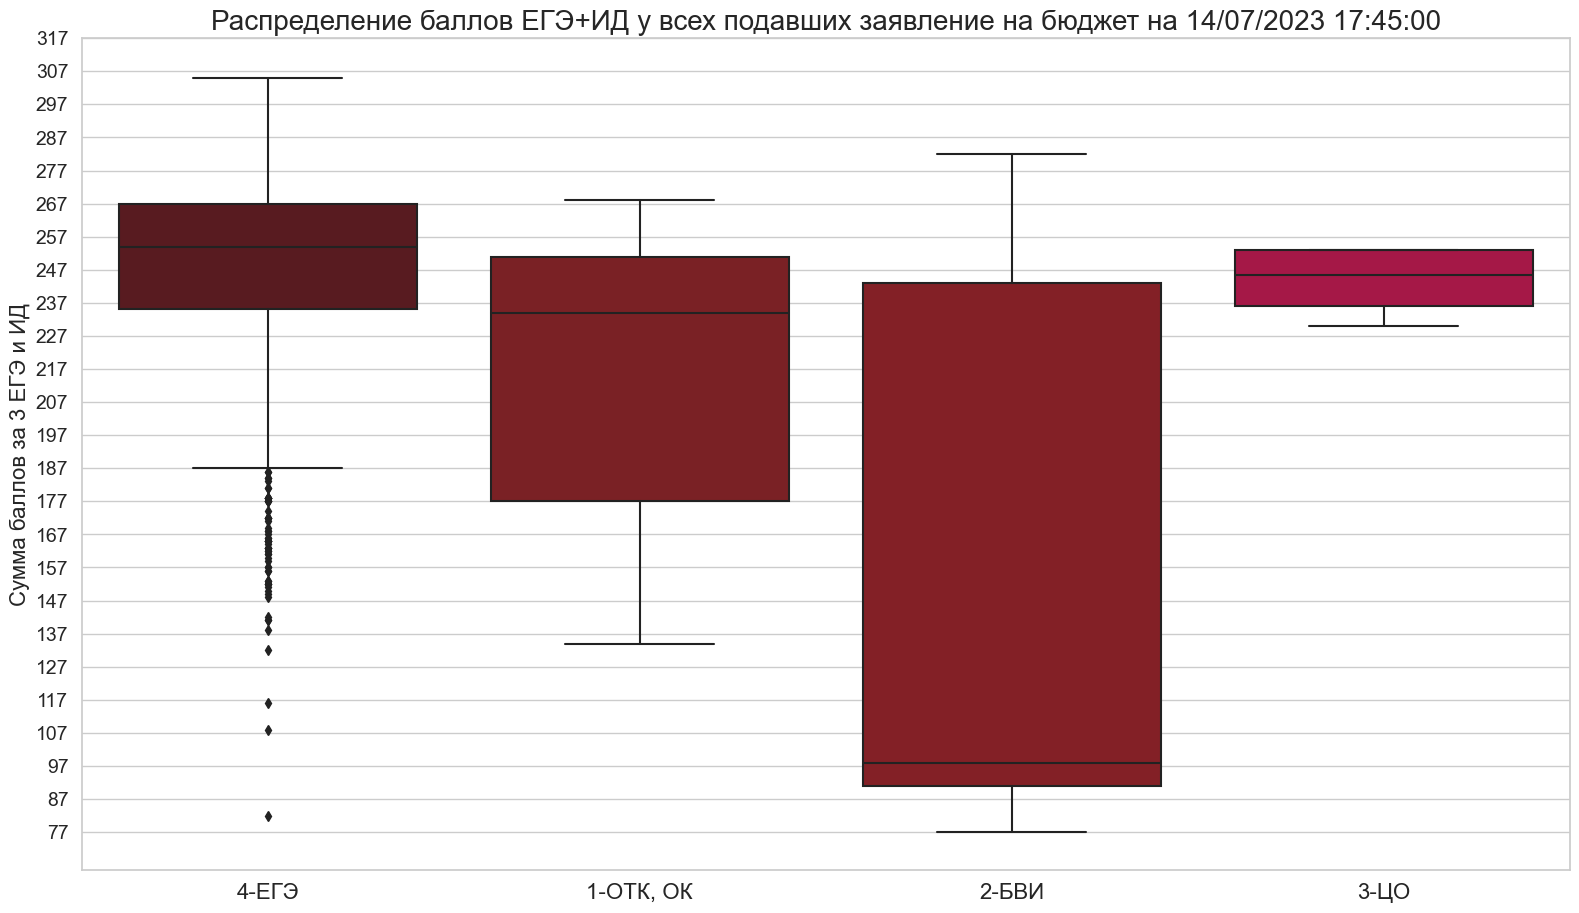

In [32]:
boxplot4_all(balls_all, not_draw, picture)

In [33]:
def boxplot1_all(df, not_draw, picture):
    if picture:
        time = get_time()
        plt.figure(figsize=(19.2, 10.8))

        red_palette = ["#621118", "#891218", "#931018", "#BD003F"]
        colour = ['#931018']
        sns.set_theme(style='whitegrid', palette=colour)


        plt.title(f'Распределение баллов ЕГЭ+ИД у подавших заявление на бюджет лиц, которые поступают по ЕГЭ на {time}', fontsize=20)
        plt.xticks(fontsize=16)
        sns.boxplot(x='importance', y='сумма',data=df[df['importance']=='4-ЕГЭ'])

        plt.yticks(np.arange(min(df['сумма']), max(df['сумма'])+15, 10), fontsize=14)
        plt.xlabel('')
        plt.ylabel('Сумма баллов за 3 ЕГЭ и ИД', fontsize=18)

        name = '3_boxplot1_all.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)
        return(name)

'3_boxplot1_all.png'

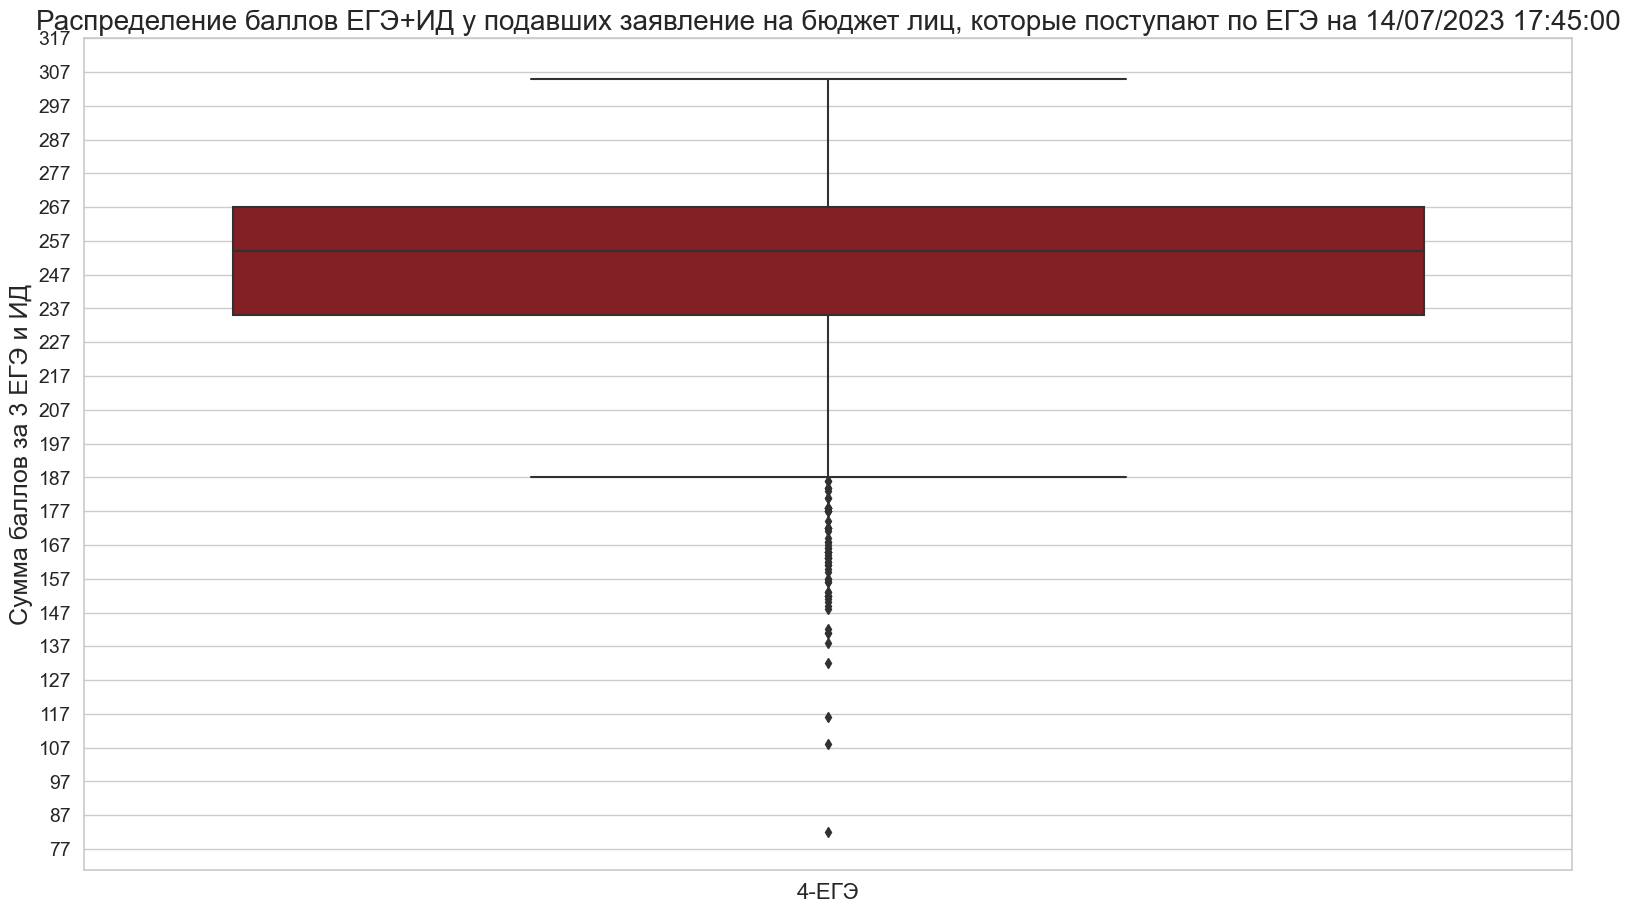

In [34]:
boxplot1_all(balls_all, not_draw, picture)

In [35]:
def scatterplot_all(df, not_draw, picture):
    if picture:    
        rb_palette = ["#931018", 'black']
        colour = ['#931018']
        sns.set_theme(style='darkgrid', palette=rb_palette)

        time = get_time()
        f, ax = plt.subplots(figsize=(19.2, 10.8), dpi= 50)

        sns.despine(f, left=True, bottom=True)

        sns.scatterplot(x='сумма', y='importance', data=df,
                        hue="Примечание (документ об образовании)", s = 300)

        plt.title(f'Распределение баллов ЕГЭ+ИД у всех подавших заявление на бюджет на {time}', fontsize=20)
        plt.xticks(np.arange(min(df['сумма']), max(df['сумма'])+15, 15), fontsize=14)
        plt.ylabel('')
        plt.yticks(fontsize=14)
        plt.xlabel('Сумма баллов за 3 ЕГЭ и ИД', fontsize=18)
        plt.legend(fontsize = 25)

        name = '4_scatterplot_all.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)

        return(name)

'4_scatterplot_all.png'

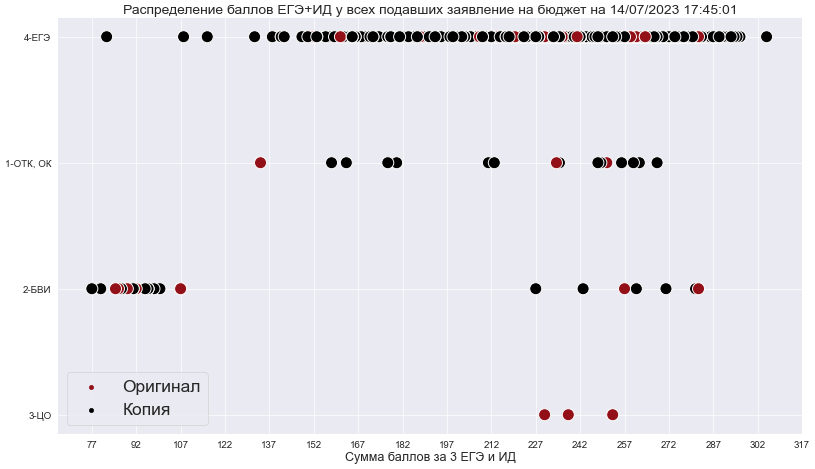

In [36]:
scatterplot_all(balls_all, not_draw, picture)

In [37]:
def hist_all(df, not_draw, picture):
    if picture:    
        red_palette = ["#621118", "#891218", "#931018", "#BD003F"]
        colour = ['#931018']
        sns.set_theme(style='whitegrid', palette=colour)


        time = get_time()
        plt.figure(figsize=(19.2, 10.8))
        plt.hist(df['сумма'], bins=50)


        plt.ylabel('Количество', fontsize=16)
        plt.title(f'Количество всех подавших заявление на бюджет в разбивке по количеству баллов за ЕГЭ+ИД на {time}', fontsize=16)
        plt.xticks(np.arange(min(df['сумма'])+3, max(df['сумма'])+15, 5), fontsize=12, rotation=0)

        median_sum = np.median(df['сумма'])
        mean_sum = np.mean(df['сумма'])
        mode_sum = df['сумма'].mode().values[0]
        plt.axvline(median_sum, color='orange', label = (f'Медиана = {round(median_sum, 0)}'), linewidth=6)
        plt.axvline(mean_sum, color='tomato', label = (f'Среднее арифметическое = {round(mean_sum, 0)}'), linewidth=6)
        plt.axvline(mode_sum, color='darkorange', label = (f'Самое часто встречающееся значение(мода) = {round(mode_sum, 0)}'), linewidth=6)
        plt.legend(fontsize = 16)

        name = '5_hist_all.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)


        return(name)

'5_hist_all.png'

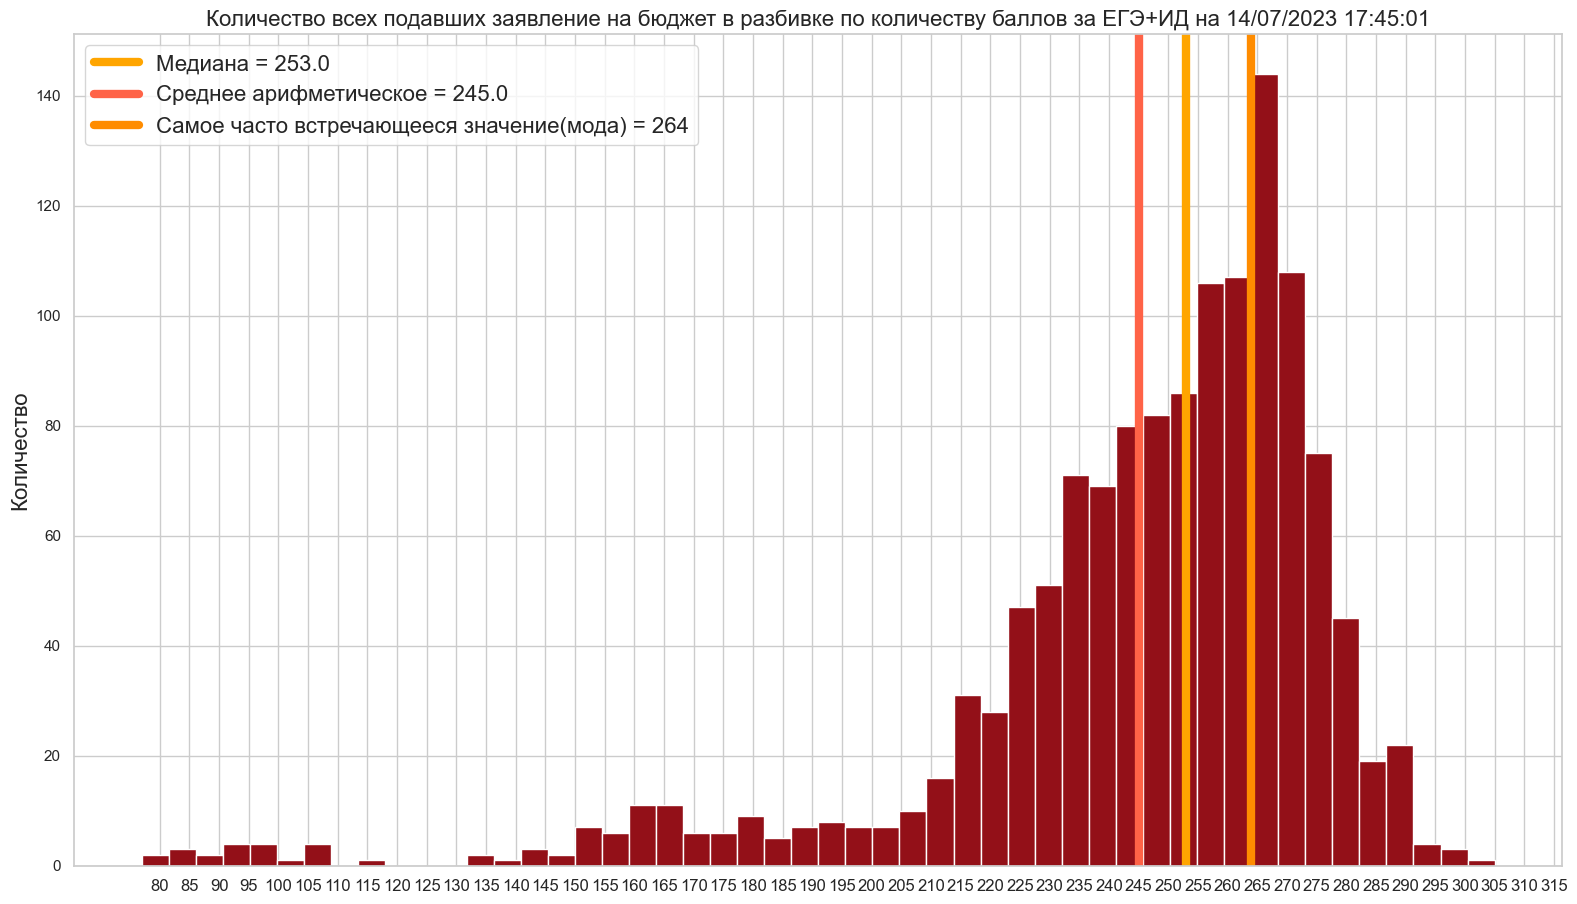

In [38]:
hist_all(balls_all, not_draw, picture)

In [39]:
def hist_all_ege(df, not_draw, picture):
    if picture:
        red_palette = ["#621118", "#891218", "#931018", "#BD003F"]
        colour = ['#931018']
        sns.set_theme(style='whitegrid', palette=colour)

        time = get_time()
        plt.figure(figsize=(19.2, 10.8))
        plt.hist(df[df['importance']=='4-ЕГЭ']['сумма'], bins=50)

        plt.ylabel('Количество', fontsize=16)
        plt.title(f'Количество подавших заявление на бюджет только по ЕГЭ в разбивке по количеству баллов за ЕГЭ+ИД на {time}', fontsize=16)
        plt.xticks(np.arange(min(df['сумма'])+3, max(df['сумма'])+15, 5), fontsize=12, rotation=0)

        median_sum = np.median(df[df['importance']=='4-ЕГЭ']['сумма'])
        mean_sum = np.mean(df[df['importance']=='4-ЕГЭ']['сумма'])
        mode_sum = df[df['importance']=='4-ЕГЭ']['сумма'].mode().values[0]
        plt.axvline(median_sum, color='orange', label = (f'Медиана = {round(median_sum, 0)}'), linewidth=6)
        plt.axvline(mean_sum, color='tomato', label = (f'Среднее арифметическое = {round(mean_sum, 0)}'), linewidth=6)
        plt.axvline(mode_sum, color='darkorange', label = (f'Самое часто встречающееся значение(мода) = {round(mode_sum, 0)}'), linewidth=6)
        plt.legend(fontsize = 16)

        name = '6_hist_all_ege.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)

        return(name)

'6_hist_all_ege.png'

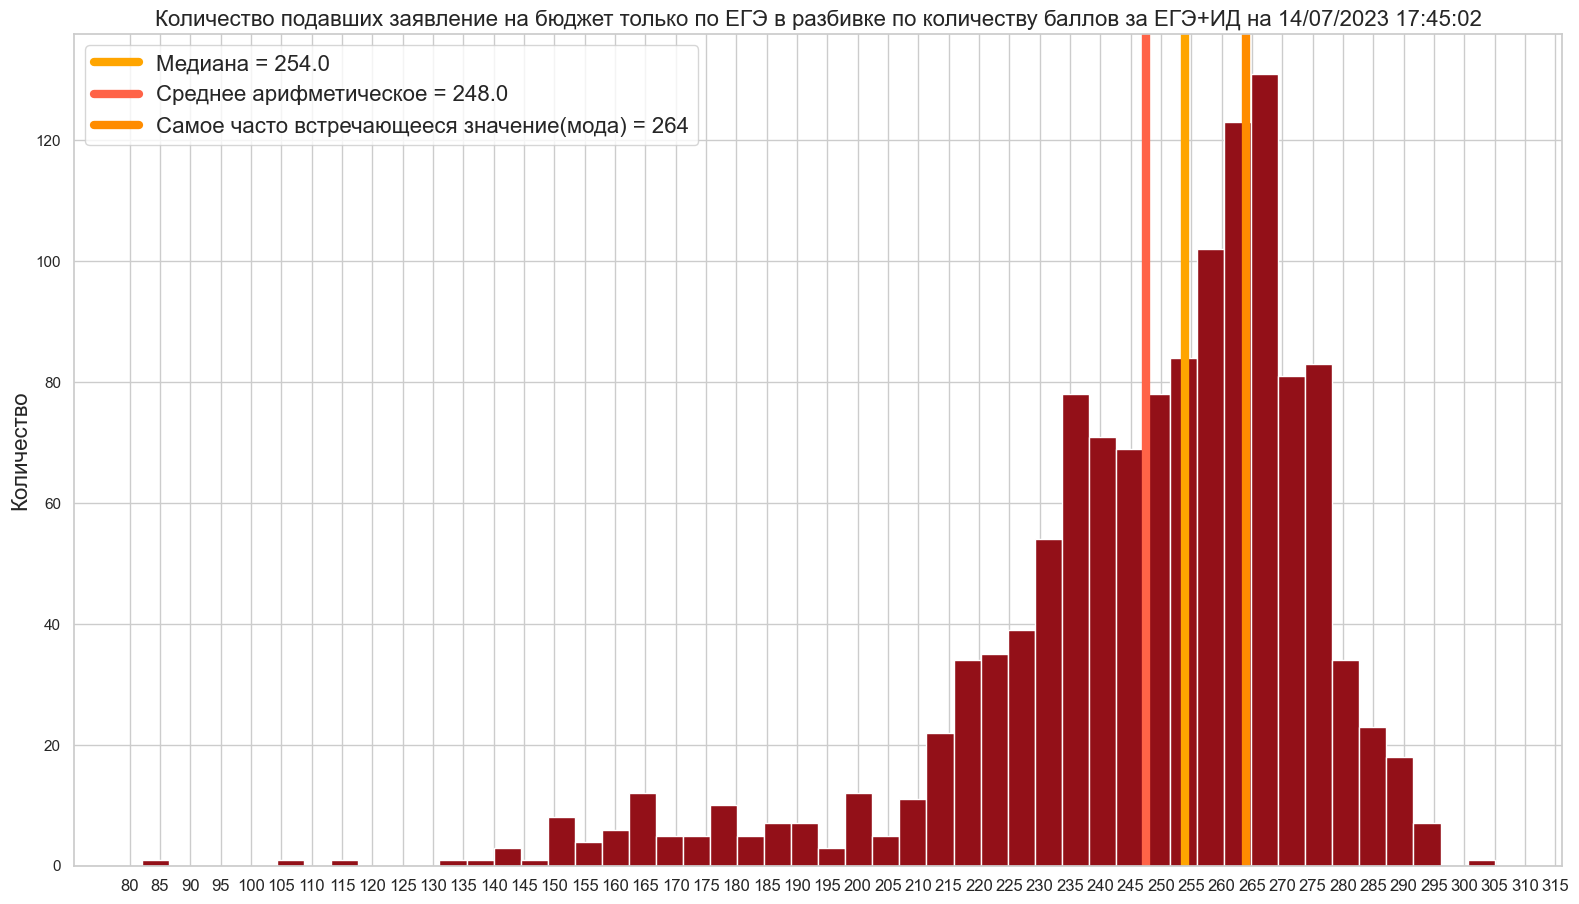

In [40]:
hist_all_ege(balls_all, not_draw, picture)

### Рассматриваются только 1 и 2 приоритеты, как наиболее высокая вероятность, что абитуриент принесёт оригинал

In [41]:
def boxplot4_12(df, not_draw, picture):    
    if picture:
        red_palette = ["#621118", "#891218", "#931018", "#BD003F"]
        colour = ['#931018']
        sns.set_theme(style='whitegrid', palette=red_palette)


        time = get_time()
        plt.figure(figsize=(19.2, 10.8))
        plt.title(f'Распределение баллов ЕГЭ+ИД у подавших заявление на бюджет лиц, которые поступают только по ЕГЭ на {time} (1 и 2 приоритеты)', fontsize=20)
        plt.xticks(fontsize=16)
        sns.boxplot(x='importance', y='сумма',data=df)


        plt.yticks(np.arange(min(df['сумма']), max(df['сумма'])+15, 10), fontsize=14)
        plt.xlabel('')
        plt.ylabel('Сумма баллов за 3 ЕГЭ и ИД', fontsize=16)

        name = '7_boxplot4_12.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)

        return(name)

'7_boxplot4_12.png'

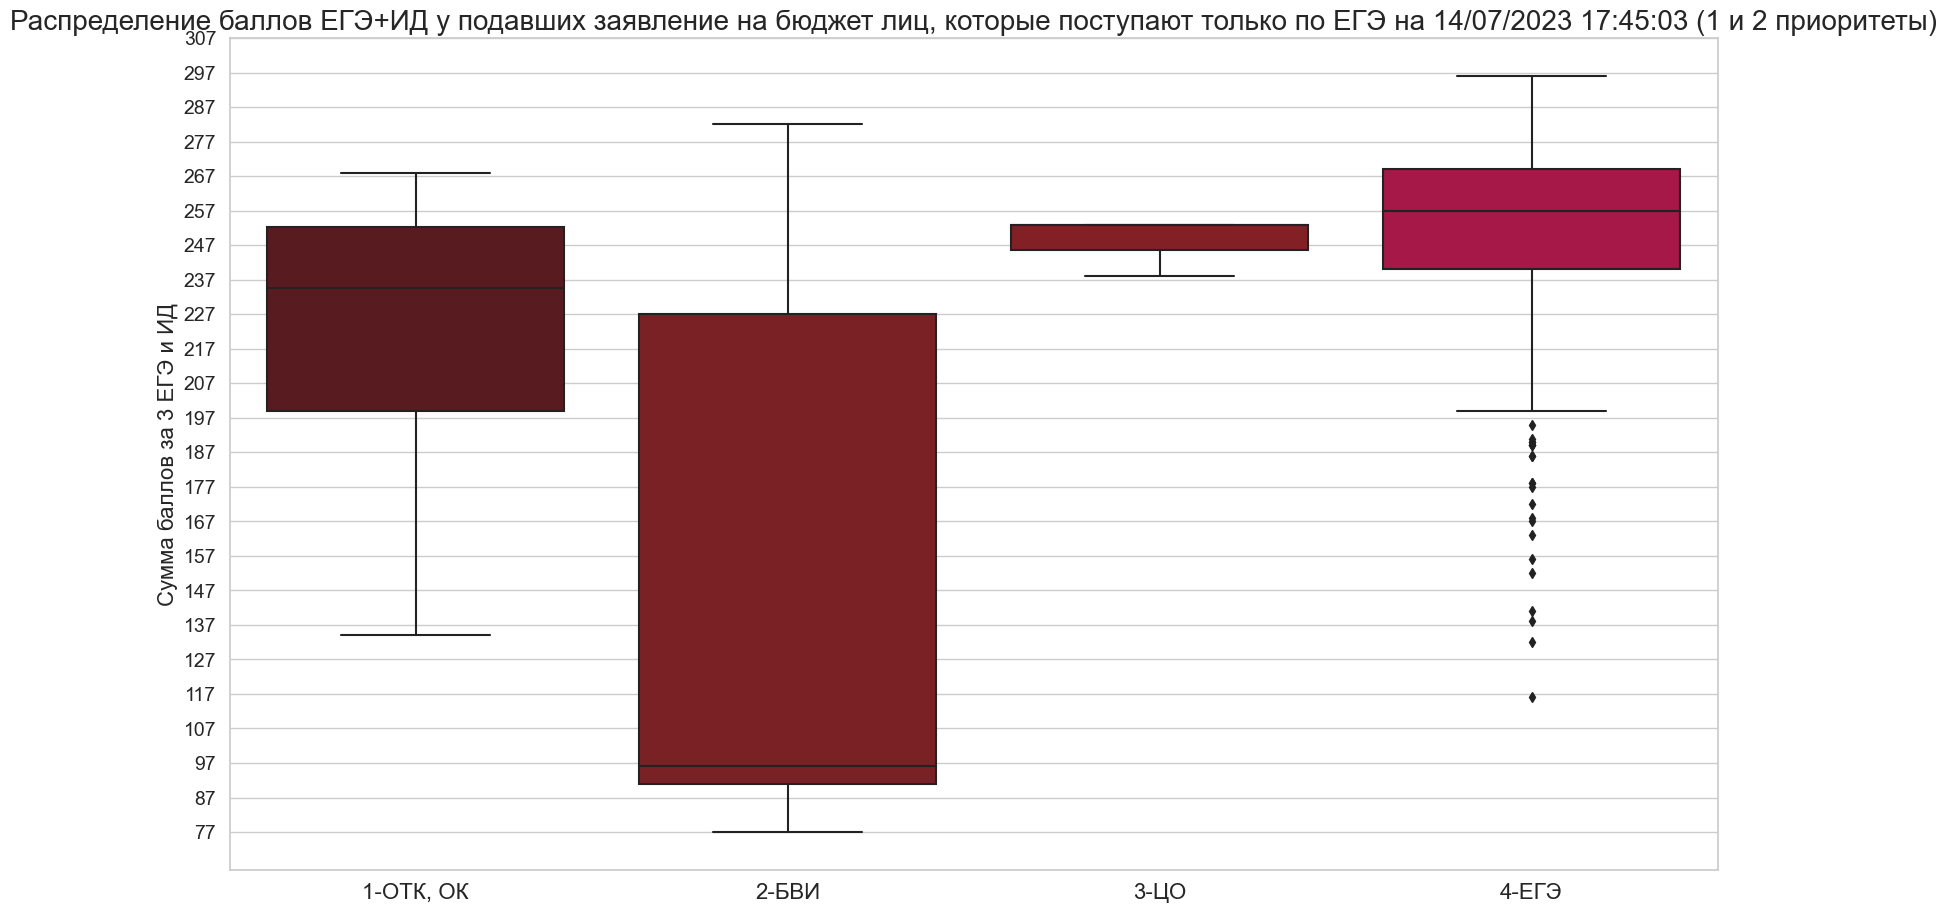

In [42]:
boxplot4_12(prio12, not_draw, picture)

In [43]:
def boxplot1_12(df, not_draw, picture):
    if picture:
        time = get_time()
        plt.figure(figsize=(19.2, 10.8))


        red_palette = ["#621118", "#891218", "#931018", "#BD003F"]
        colour = ['#931018']
        sns.set_theme(style='whitegrid', palette=colour)



        plt.title(f'Распределение баллов ЕГЭ+ИД у подавших заявление на бюджет на {time} (1 и 2 приоритеты)', fontsize=20)
        plt.xticks(fontsize=16)
        sns.boxplot(x='importance', y='сумма',data=df[df['importance']=='4-ЕГЭ'])
        # plt.savefig('boxplotITOG1.png', dpi=100)

        plt.yticks(np.arange(min(df['сумма']), max(df['сумма'])+15, 10), fontsize=14)
        plt.xlabel('')
        plt.ylabel('Сумма баллов за 3 ЕГЭ и ИД', fontsize=18)

        name = '8_boxplot1_12.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)

        return(name)

'8_boxplot1_12.png'

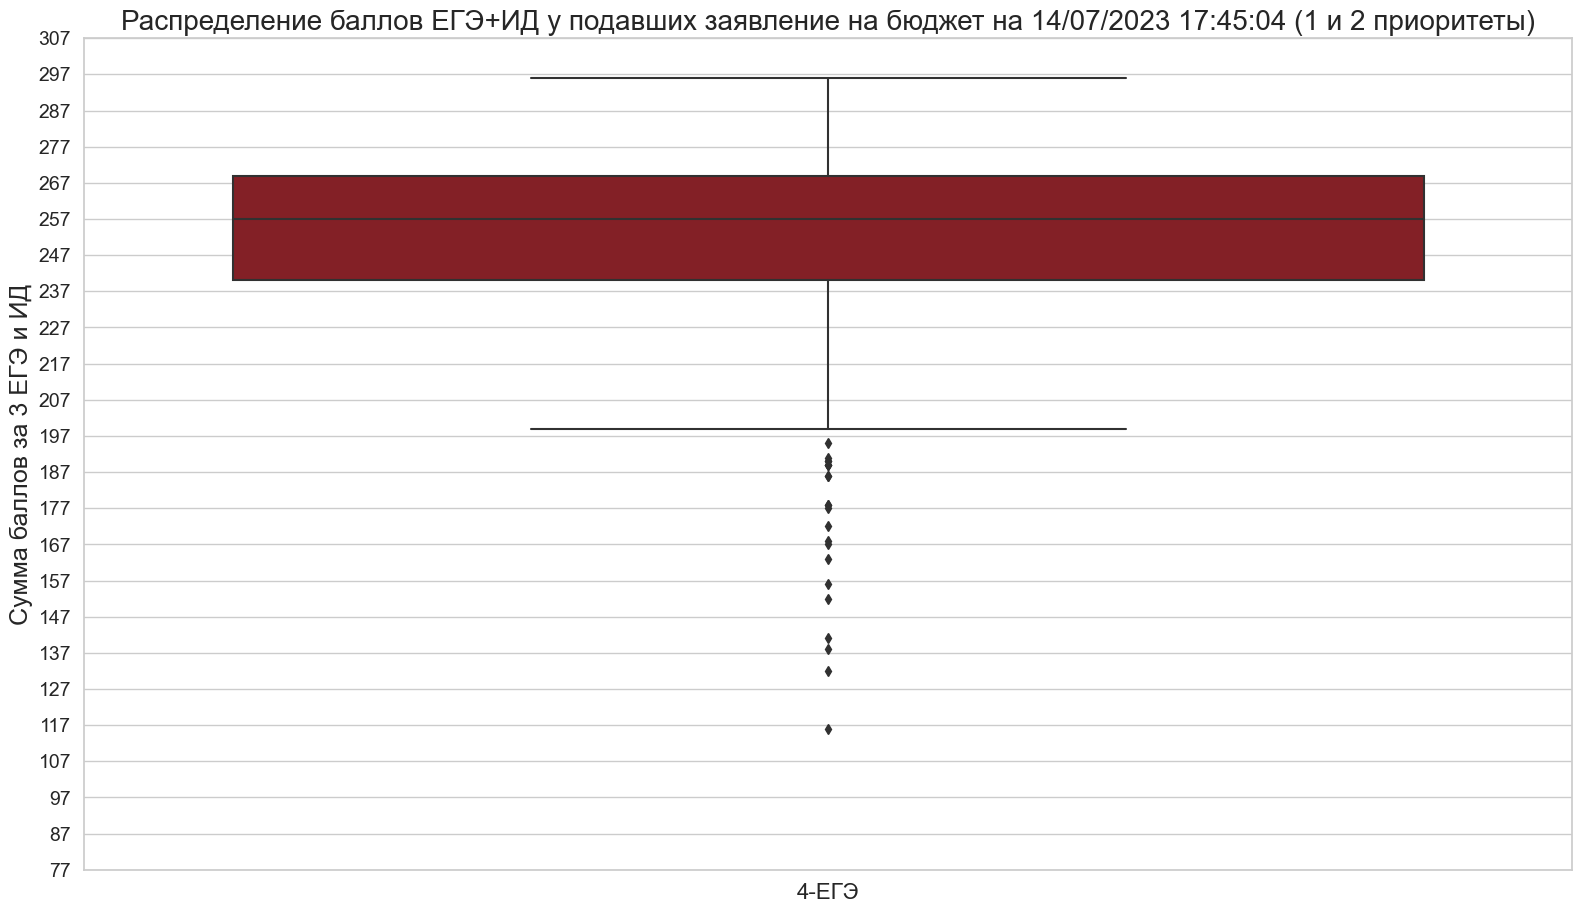

In [44]:
boxplot1_12(prio12, not_draw, picture)

In [45]:
def scatterplot_12(df, not_draw, picture):
    
    if picture:
        time = get_time()
        f, ax = plt.subplots(figsize=(19.2, 10.8), dpi= 100)

        rb_palette = ["#931018", "black"]
        colour = ['#931018']
        sns.set_theme(style='darkgrid', palette=rb_palette)

        sns.despine(f, left=True, bottom=True)

        sns.scatterplot(x='сумма', y='importance', data=df,
                        hue="Примечание (документ об образовании)", s=400)

        plt.title(f'Распределение баллов ЕГЭ+ИД у подавших заявление на бюджет на {time} (1 и 2 приоритеты)', fontsize=20)
        plt.xticks(np.arange(min(df['сумма'])+3, max(df['сумма'])+15, 10), fontsize=14)
        plt.ylabel('')
        plt.yticks(fontsize=14)
        plt.xlabel('Сумма баллов за 3 ЕГЭ и ИД', fontsize=18)
        plt.legend(fontsize = 25)

        name = '9_scatterplot_12.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)

        return(name)

'9_scatterplot_12.png'

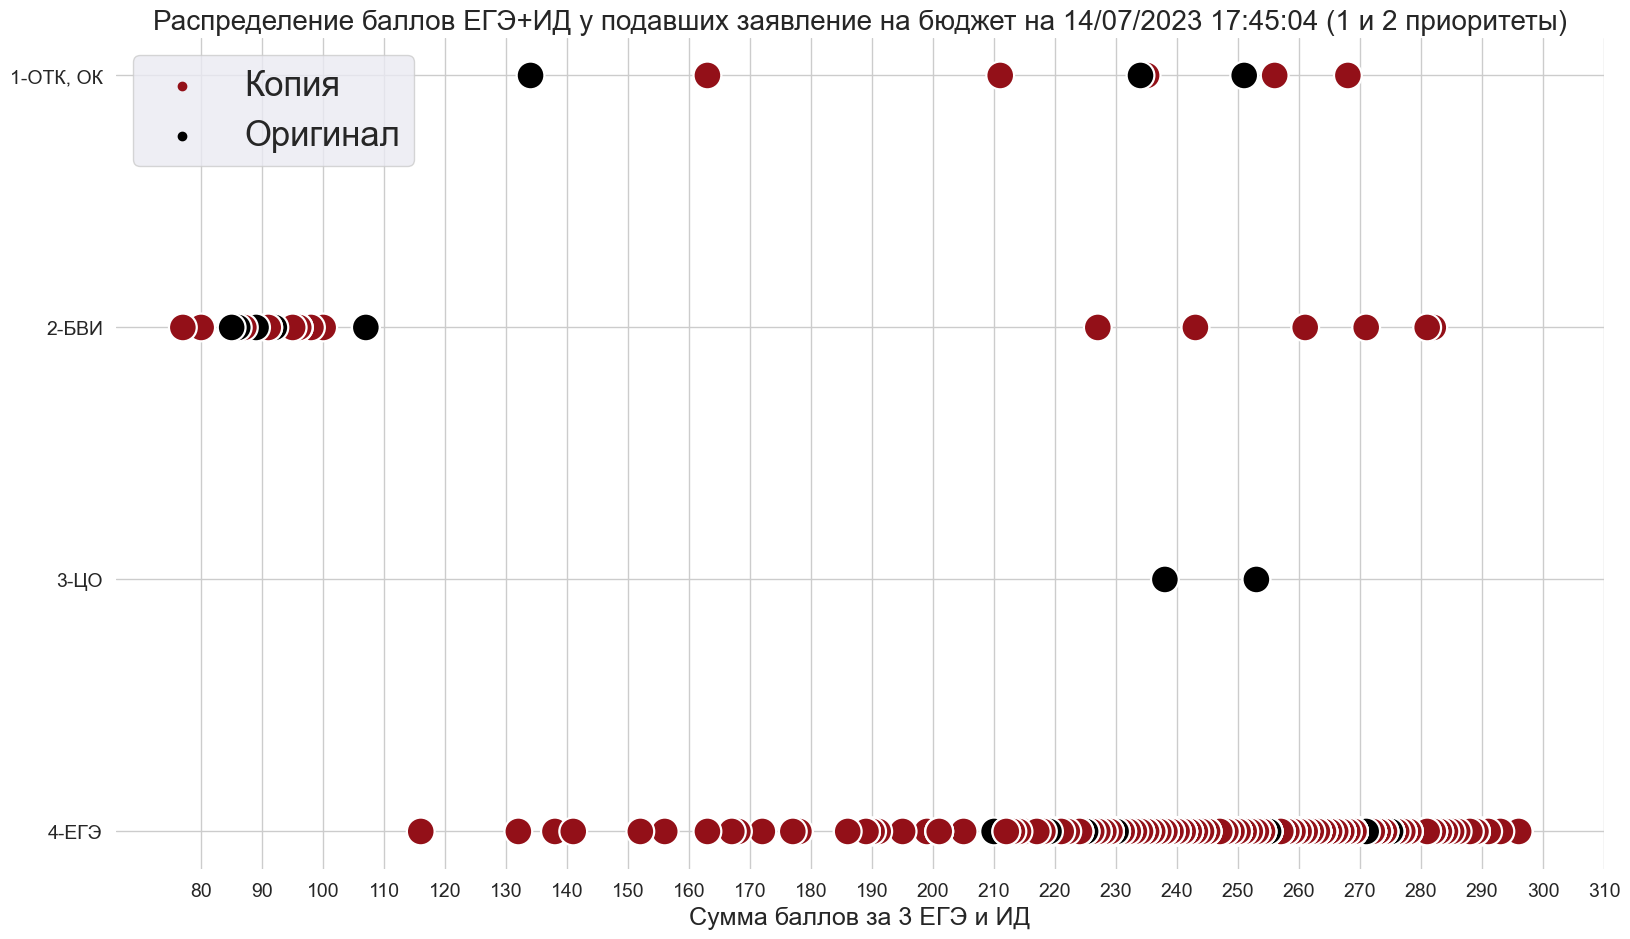

In [46]:
scatterplot_12(prio12, not_draw, picture)

In [47]:
def hist_12(df, not_draw, picture):
    if picture:
        red_palette = ["#621118", "#891218", "#931018", "#BD003F"]
        colour = ['#931018']
        sns.set_theme(style='whitegrid', palette=colour)

        time = get_time()
        plt.figure(figsize=(19.2, 10.8))
        plt.hist(df['сумма'], bins=70)

        plt.ylabel('Количество', fontsize=16)
        plt.title(f'Количество подавших заявление на бюджет(БВИ,ОК,ОТК и тд) в разбивке по количеству баллов за ЕГЭ + ИД на {time} (1 и 2 приоритеты)', fontsize=16)
        plt.xticks(np.arange(min(df['сумма'])+3, max(df['сумма'])+15, 10), fontsize=12, rotation=0)

        median_sum = np.median(df['сумма'])
        mean_sum = np.mean(df['сумма'])
        mode_sum = df['сумма'].mode().values[0]
        plt.axvline(median_sum, color='orange', label = (f'Медиана = {round(median_sum, 0)}'), linewidth=6)
        plt.axvline(mean_sum, color='tomato', label = (f'Среднее арифметическое = {round(mean_sum, 0)}'), linewidth=6)
        plt.axvline(mode_sum, color='darkorange', label = (f'Самое часто встречающееся значение(мода) = {round(mode_sum, 0)}'), linewidth=6)
        plt.legend(fontsize = 16)

        name = '10_hist_12.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)

        return(name)

'10_hist_12.png'

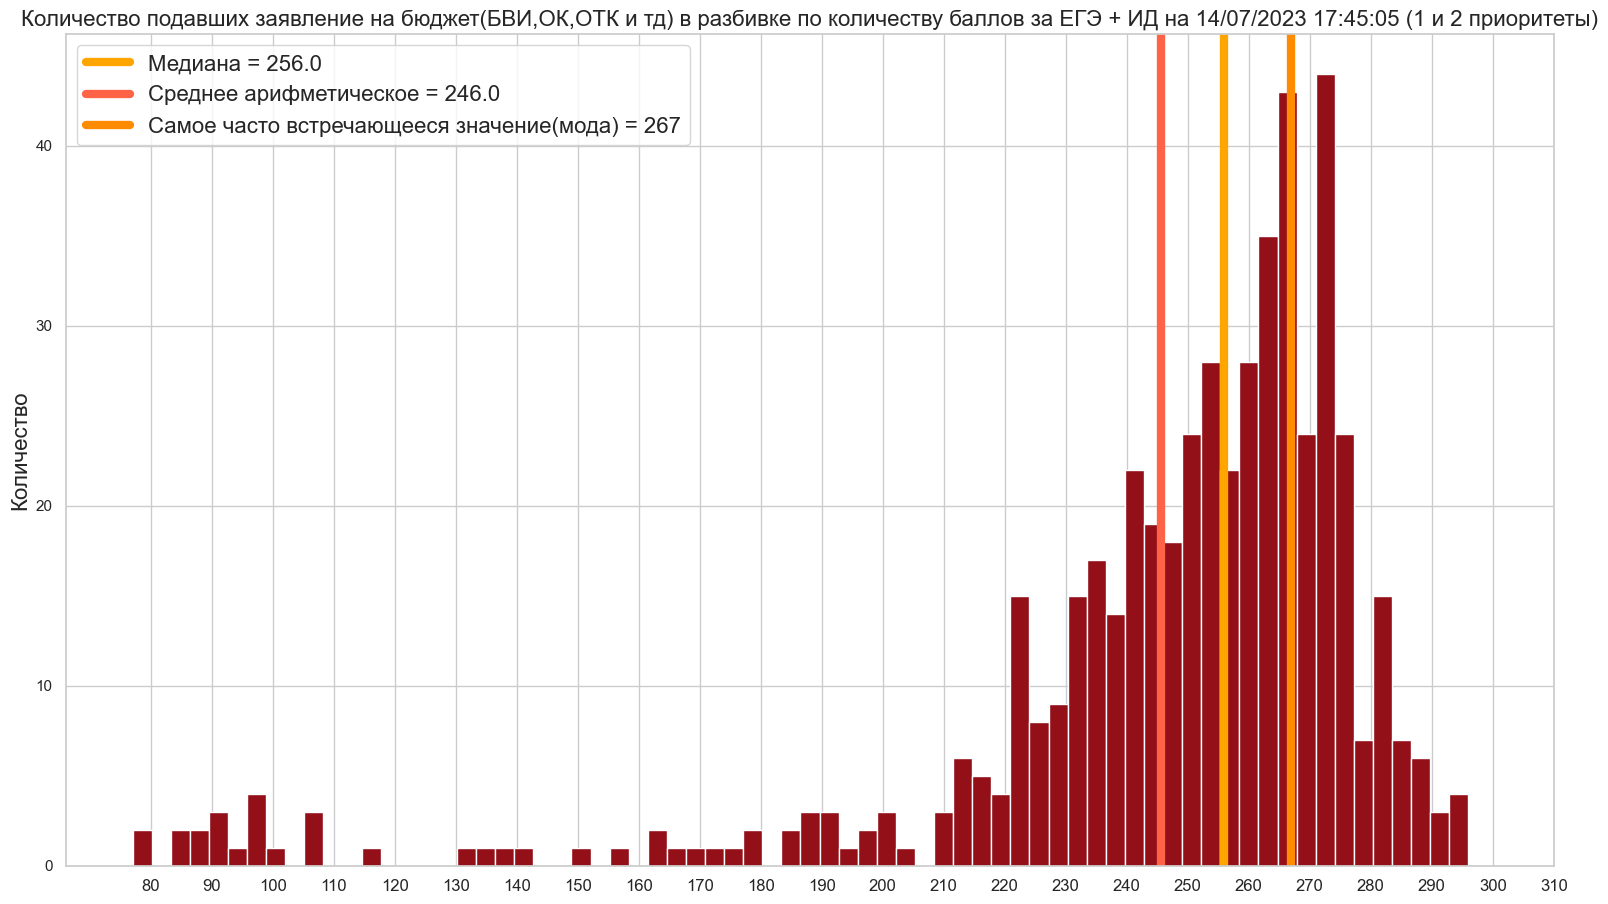

In [48]:
hist_12(prio12, not_draw, picture)

In [49]:
def hist_12_ege(df, not_draw, picture):
    if picture:
        red_palette = ["#621118", "#891218", "#931018", "#BD003F"]
        colour = ['#931018']
        sns.set_theme(style='whitegrid', palette=colour)

        time = get_time()
        plt.figure(figsize=(19.2, 10.8))
        plt.hist(df[df['importance']=='4-ЕГЭ']['сумма'], bins=50)

        plt.ylabel('Количество', fontsize=16)
        plt.title(f'Количество поступающих только по ЕГЭ в разбивке по количеству баллов за ЕГЭ + ИД на {time} (1 и 2 приоритеты)', fontsize=16)
        plt.xticks(np.arange(min(df['сумма'])+3, max(df['сумма'])+15, 5), fontsize=12, rotation=0)

        median_sum = np.median(df[df['importance']=='4-ЕГЭ']['сумма'])
        mean_sum = np.mean(df[df['importance']=='4-ЕГЭ']['сумма'])
        mode_sum = df[df['importance']=='4-ЕГЭ']['сумма'].mode().values[0]
        plt.axvline(median_sum, color='orange', label = (f'Медиана = {round(median_sum, 0)}'), linewidth=6)
        plt.axvline(mean_sum, color='tomato', label = (f'Среднее арифметическое = {round(mean_sum, 0)}'), linewidth=6)
        plt.axvline(mode_sum, color='darkorange', label = (f'Самое часто встречающееся значение(мода) = {round(mode_sum, 0)}'), linewidth=6)
        plt.legend(fontsize = 16)


        name = '11_hist_12_ege.png'
        plt.savefig(name, dpi=100)
        plt.close(not_draw)

        return(name)

'11_hist_12_ege.png'

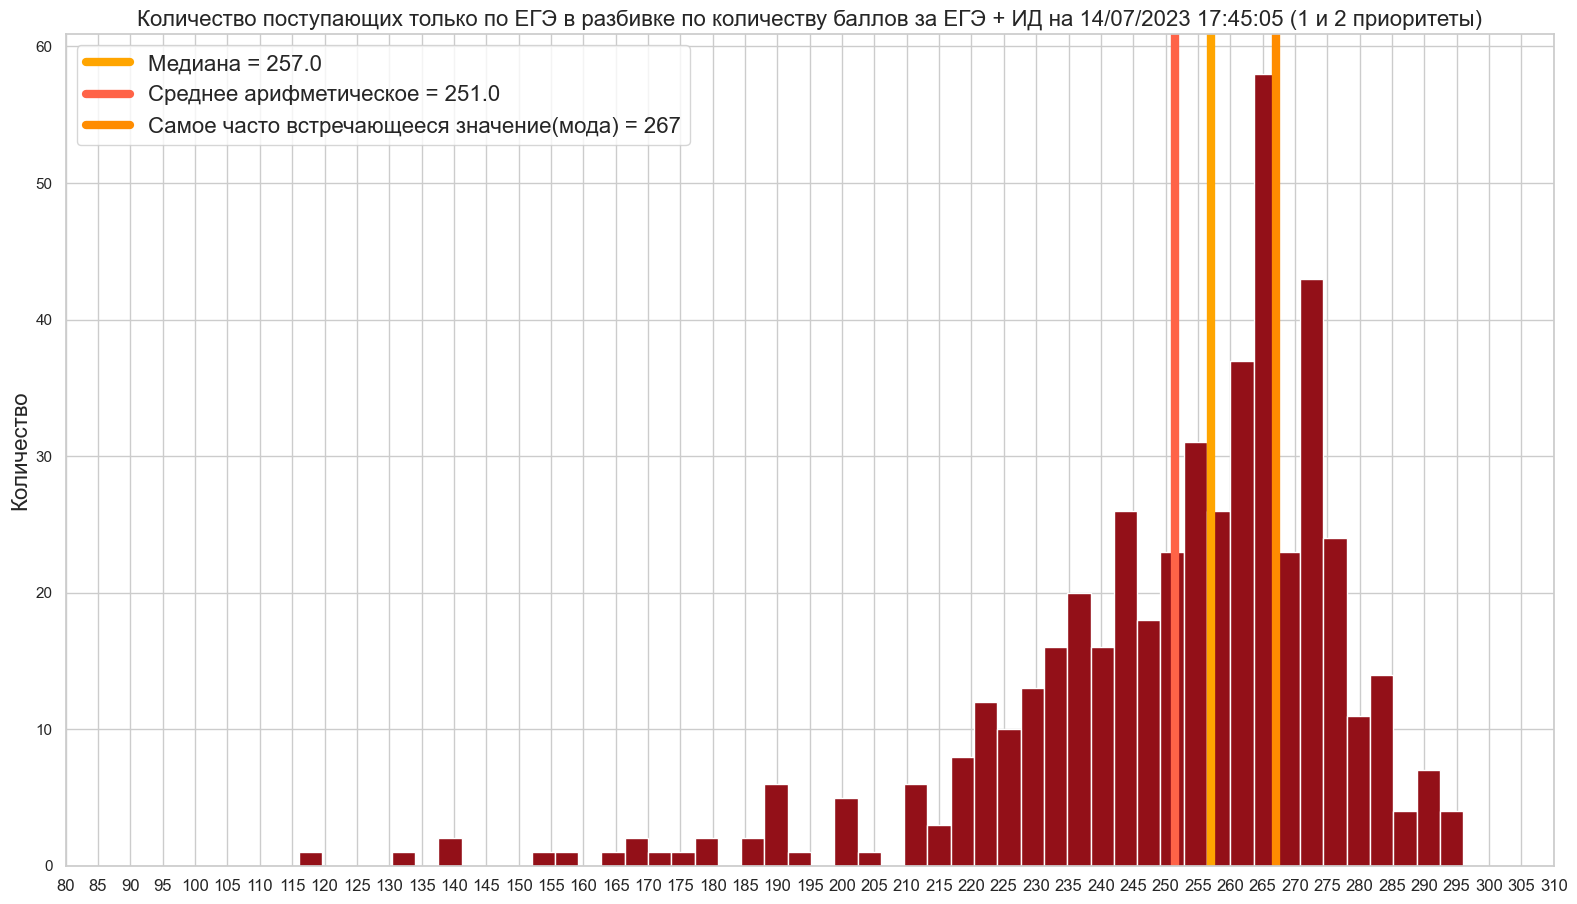

In [50]:
hist_12_ege(prio12, not_draw, picture)

## Проходной балл при условии, что все первые 70 человек подадут оригинал документа

In [51]:
def get_good_ball_all(balls_all, time):
    good_ball_all = balls_all.loc[69, 'сумма']
    result = f'''Проходной балл по всем поданным заявлениям на {time} = {good_ball_all}

Как стоит его интерпретировать:
1) Ваш фактический балл НИЖЕ(<) этого проходного балла. В таком случае, не стоит волноваться, так как он лишь позволяет понять самый неблагоприятный для вас расклад, при котором ВСЕ! 70 студентов, у кого этот балл выше проходного действительно решат поступить на эту образовательную программу. С добавлением системы приоритетов вероятность этого увеличилась по сравнению с прошлым годом, но, тем не менее, она мала.
2) Ваш фактический балл НЕ МЕНЕЕ(>=) этого проходного балла. В таком случае, чем он больше, тем с большей вероятностью вы попадёте к нам, на Отделение экономики совокупность программ "Цифровая экономика" и "Экономика и финансы". Однако он может увеличиться, если подадут заявление абитуриенты с баллом выше проходного.'''
    return(result)

In [52]:
def get_good_ball_originals(balls_originals, time):
    if balls_originals.loc[69, 'Примечание (документ об образовании)'] == 'Оригинал':
        good_ball_originals = balls_originals.loc[69, 'сумма']
        result = f'''Проходной балл по оригиналам на {time} = {good_ball_originals}

С большей долей уверенности указывает на то, каким будет истинный проходной балл, так как когда абитуриенты подают оригинал документа, то они показывают свои истинные цели, куда желают поступить.

Как стоит его интерпретировать:
1) Ваш фактический балл НИЖЕ(<) этого проходного балла. Проходной балл по оригиналам позволяет понять самый неблагоприятный для вас расклад, при котором все 70 студентов, у кого этот балл выше проходного действительно решат поступить на эту образовательную программу. 
2) Ваш фактический балл НЕ МЕНЕЕ(>=) этого проходного балла. В таком случае, чем он больше, тем с большей вероятностью вы попадёте к нам, на Отделение экономики совокупность программ "Цифровая экономика" и "Экономика и финансы". Однако он может увеличиться, если подадут заявление или оригиналы абитуриенты с баллом выше проходного.'''
    else:
        quantity = len(balls_originals[balls_originals['Примечание (документ об образовании)'] == 'Оригинал'])
        result = f'Проходной балл по оригиналам на {time} неизвестен, так как всего подано оригиналов только {quantity}'
    return(result)


## Функция загрузки изображений из заданного списка

In [53]:
navigation_0 = "0_навигация.jpg"
comparison_1 = "1_сравнение.jpg"
jobs = '12_jobs.jpg'
courses_jobs = '13_courses_jobs.jpg'
andrey = '14_andrey.jpg'
stas = '15_stas.jpg'
kotenok = '16_kotenok.jpg'
obshaga = '17_obshaga.jpg'

In [54]:
def upload_photos(photos_list):
    attachments = []
    uploaded_images = upload.photo_messages(photos = photos_list)
    for i in range(len(uploaded_images)):
        attachments.append('photo{}_{}'.format(uploaded_images[i]['owner_id'], uploaded_images[i]['id']))
    return(attachments)

## Функция получения таблицы, её преобразования, визуализации данных, сохранения и загрузки графиков
кроме того, получение информации о том, насколько увеличились конкурсные списки с момента последнего обновления, получение проходного балла(при условии, что все 70 человек в отсортированной таблице подадут заявление), получение проходного балла для оригиналов(аналогично)

In [55]:
def get_balls_info(not_draw, picture):
    
    if picture:
        # Предзагруженные файлы в папку
        photos_list = [navigation_0, comparison_1]
    
    # scrapping
    result = get_parsing_data()
    balls = result[0]
    dif_quantity = result[1]
    
    # сортировка данных в таблицах + их сохранение
    balls_all = balls_imp_sort_all(balls, 'Номер дела')
    balls_originals = get_balls_originals(balls_all)
    time = get_time()
    prio12 = get_prio12()
    
    # графики для всех приоритетов + их сохранение
    name2 = boxplot4_all(balls_all, not_draw, picture)
    name3 = boxplot1_all(balls_all, not_draw, picture)
    name4 = scatterplot_all(balls_all, not_draw, picture)
    name5 = hist_all(balls_all, not_draw, picture)
    name6 = hist_all_ege(balls_all, not_draw, picture)
    
    # графики для 1 и 2 приоритета + их сохранение
    name7 = boxplot4_12(prio12, not_draw, picture)
    name8 = boxplot1_12(prio12, not_draw, picture)
    name9 = scatterplot_12(prio12, not_draw, picture)
    name10 = hist_12(prio12, not_draw, picture)
    name11 = hist_12_ege(prio12, not_draw, picture)
    
    # добавление названий файлов графиков в список
    if picture:
        photos_list.append(name2)
        photos_list.append(name3)
        photos_list.append(name4)
        photos_list.append(name5)
        photos_list.append(name6)
        photos_list.append(name7)
        photos_list.append(name8)
        photos_list.append(name9)
        photos_list.append(name10)
        photos_list.append(name11)
        photos_list.append(jobs)
        photos_list.append(courses_jobs)
        photos_list.append(andrey)
        photos_list.append(stas)
        photos_list.append(kotenok)
        photos_list.append(obshaga)
        
    # проходные баллы
    good_ball_all = get_good_ball_all(balls_all, time)
    good_ball_originals = get_good_ball_originals(balls_originals, time)

    # подгрузка фото в ВК
    if picture:
        attachments1 = upload_photos(photos_list[:10])
    else:
        attachments1 = []
    if picture:
        attachments2 = upload_photos(photos_list[10:])
    else:
        attachments2 = []
    
    return(dif_quantity, good_ball_all, good_ball_originals, attachments1, attachments2)

In [56]:
# get_balls_info(not_draw = True, picture = True)[0]

## Создание вариаций клавиатур и кнопок в них

In [57]:
menu = VkKeyboard(one_time=True)
menu.add_button('Поступление', color=VkKeyboardColor.SECONDARY)
menu.add_button('Учебный процесс', color=VkKeyboardColor.PRIMARY)
menu.add_line()
menu.add_button('Проживание', color=VkKeyboardColor.PRIMARY)
menu.add_button('Трудоустройство', color=VkKeyboardColor.SECONDARY)
menu.add_line()
menu.add_button('Статистика и проходной балл', color=VkKeyboardColor.POSITIVE)

uch_process = VkKeyboard(one_time=True)
uch_process.add_button('Обучение', color=VkKeyboardColor.PRIMARY)
uch_process.add_button('Преподаватели', color=VkKeyboardColor.PRIMARY)
uch_process.add_line()
uch_process.add_button('Различие ЭиФ и ЦЭ', color=VkKeyboardColor.PRIMARY)
uch_process.add_button('Главное меню', color=VkKeyboardColor.POSITIVE)

to_uch_process = VkKeyboard(one_time=True)
to_uch_process.add_button('Учебный процесс', color=VkKeyboardColor.PRIMARY)
to_uch_process.add_button('Написать студентам', color=VkKeyboardColor.POSITIVE)

to_menu = VkKeyboard(one_time=True)
to_menu.add_button('Главное меню', color=VkKeyboardColor.PRIMARY)

statistics = VkKeyboard(one_time=True)
statistics.add_button('Проходной балл', color=VkKeyboardColor.POSITIVE)
#statistics.add_button('Проходной балл(оригиналы)', color=VkKeyboardColor.PRIMARY)
statistics.add_line()
statistics.add_button('Графики', color=VkKeyboardColor.PRIMARY)
statistics.add_button('Графики(1 и 2 приоритет)', color=VkKeyboardColor.SECONDARY)
statistics.add_line()
statistics.add_button('Главное меню', color=VkKeyboardColor.POSITIVE)

to_statistics = VkKeyboard(one_time=True)
to_statistics.add_button('Статистика', color=VkKeyboardColor.SECONDARY)

job = VkKeyboard(one_time=True)
job.add_button('Разные вопросы', color=VkKeyboardColor.PRIMARY)
job.add_line()
job.add_button('НИР/Практика', color=VkKeyboardColor.PRIMARY)
job.add_line()
job.add_button('Написать студентам', color=VkKeyboardColor.SECONDARY)
job.add_line()
job.add_button('Главное меню', color=VkKeyboardColor.POSITIVE)

living = VkKeyboard(one_time=True)
living.add_button('Общежития', color=VkKeyboardColor.PRIMARY)
living.add_button('ГЖК', color=VkKeyboardColor.PRIMARY)
living.add_line()
living.add_button('АТиСО', color=VkKeyboardColor.PRIMARY)
living.add_button('Главное меню', color=VkKeyboardColor.POSITIVE)

to_living = VkKeyboard(one_time=True)
to_living.add_button('Проживание', color=VkKeyboardColor.PRIMARY)
to_living.add_button('Написать студентам', color=VkKeyboardColor.POSITIVE)

admission = VkKeyboard(one_time=True)
admission.add_button('Система приоритетов', color=VkKeyboardColor.PRIMARY)
# admission.add_button('чото', color=VkKeyboardColor.PRIMARY)
admission.add_line()
# admission.add_button('чото', color=VkKeyboardColor.PRIMARY)
admission.add_button('Главное меню', color=VkKeyboardColor.POSITIVE)

to_admission = VkKeyboard(one_time=True)
to_admission.add_button('Поступление', color=VkKeyboardColor.PRIMARY)
to_admission.add_button('Написать студентам', color=VkKeyboardColor.POSITIVE)

## Основной код: отправка сообщений, создание и сохранение таблицы с данными, которые получены при получении сообщений от абитуриентов, её визуализация

In [58]:
data_path = 'data.xlsx'
# Подгрузка датафрейма из эксельки и его визуализация
# df = pd.read_excel(data_path)
# display(df)

# Создание пустого датафрейма
df = pd.DataFrame({'user_id': pd.Series(dtype='Int64'), 'full_name':[], 'message':[], 'answer':[],
                   'vk_groups':[], 'school':[], 'city':[], 
                   'day_of_birth':pd.Series(dtype='Int64'),'month_of_birth':pd.Series(dtype='Int64'), 'birth_year':pd.Series(dtype='Int64'),
                   'score':pd.Series(dtype='Int64')
                  })

result_not_attachments = dif_quantity = get_balls_info(not_draw = True, picture = False)
result_attachments1 = get_balls_info(not_draw = True, picture = True)[3]
result_attachments2 = get_balls_info(not_draw = True, picture = True)[4]
dif_quantity = result_not_attachments[0]
good_ball_all = result_not_attachments[1]
good_ball_originals = result_not_attachments[2]
attachments1 = result_attachments1
attachments2 = result_attachments2
print('done')

counter = 0
for event in longpoll.listen():
    if event.type == VkEventType.MESSAGE_NEW and event.text and event.to_me:
        sender = event.user_id
        full_name = info(sender)[2]
        received_message = event.text
        user_groups = group_list(sender) # функция добавления групп в ВК в список
        school = info(sender)[0] # функция поиска школы пользователя
        city = info(sender)[1]
        day = info(sender)[3]
        month = info(sender)[4]
        year = info(sender)[5]
        score = None
        
        counter += 1
        
        # Ветвление
        if received_message == 'Учебный процесс':
            answer = 'Выберите нужный раздел'
            # Различие программ ЭиФ и ЦЭ, Обучение, Преподаватели
            write_only_message_keyboard(sender, answer, uch_process)
            
        elif received_message == 'Различие ЭиФ и ЦЭ':
            answer = '''Общие дисциплины для обеих программ выделены белыми областями, на них студенты обучаются вместе. 
Различия выделены бордовым цветом, такие предметы студенты изучают отдельно в соответствии с выбранной программой. 
Однако, если студент ЭиФ захочет изучить дисциплину Цифровой экономики (или наоборот), то он имеет возможность подать заявление в деканат и выбрать данную дисциплину факультативно.'''
            # Текст + картинка[1]
            write_message_keyboard(sender, answer, attachments1[1], to_uch_process)
        elif received_message == 'Преподаватели':
            answer = '''Узнать о преподавателях Отделения экономики вы можете по этой ссылке:
https://vk.com/wall-16368476?q=%23%D0%9F%D1%80%D0%B5%D0%BF%D0%BE%D0%B4%D0%B0%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D0%9E%D0%AD'''
            # Ссылка на посты о преподавателях
            write_only_message_keyboard(sender, answer, to_uch_process)  
        elif received_message == 'Обучение':
            answer = '''У нас на Отделении экономики реализуются 3 программы: цифровая экономика, экономика и финансы, прикладная математика в экономике. Последняя программа - совместно с МФТИ.

Все эти 3 программы объединяет большой упор на математику. По объему математики они сравнимы с техническими направлениями по типу "прикладная математика" и "прикладная математика и информатика". Список преподаваемых математических дисциплин: математический анализ (2 года), алгебра (линейная и общая, 1 год), дискретная математика, теория вероятностей, теория игр, математическая статистика, дифференциальные уравнения, методы оптимизации (по семестру).

В цифровой экономике есть предметы, связанные с data science (машинное обучение, нейронные сети, SQL, продвинутое машинное обучение и т.д.).

Также достаточно сильно развита теоретическая экономика: микро- и макро-. Есть выбор между углубленным и базовым уровнем (у цифровой экономики - в том числе). Есть и финансовые курсы, причём как теоретические (как составить оптимальный портфель), так и более прикладные (про различные финансовые модели).

На этих программах - 2 года эконометрики, есть также углубленный уровень. В МГУ и ВШЭ, например, ситуация иная: только 1 год, некоторые темы проходятся и вовсе в магистратуре.

Важная особенность - сильный преподавательский состав. Многие преподаватели связаны с соответствующими факультетами/курсами ведущих вузов (МИЭФ ВШЭ, экономический факультет МГУ, ФЭН ВШЭ, мехмат МГУ). Некоторые преподаватели работают в индустрии (Яндекс), некоторые имеют степень PhD и опыт преподавания в зарубежных вузах (например, углубленный уровень по эконометрике ведет педагог, который преподавал в Великобритании).

Учится интересно, но сложно. Эти программы подойдут, если вы хотите более техническую экономику, нежели гуманитарную.

После зачисления старшие курсы помогают первокурсникам освоиться. Для них проводятся дополнительные занятия, с ними же делятся полезными ресурсами для самостоятельной подготовки.

Практические занятия проходят на станции метро Юго-Западная - на территории главного корпуса, со второго курса, возможно, раз в неделю занятия будут проходить на станции метро Коломенская. Лекции проходят дистанционно, особенно удобно для тех, кто работает или не хочет тратить время на дорогу.'''
            # Текст
            write_only_message_keyboard(sender, answer, to_uch_process)  
        elif received_message == 'Написать студентам':
            answer = '''Вы можете задать интересующие вас вопросы студентам Отделения Экономики:
https://vk.com/lovechkina16 - 4 курс
https://vk.com/twerilla - 3 курс
https://vk.com/awwwwwwwocado - 3 курс
https://vk.com/idzlatinka_necheporchuk - 3 курс
https://vk.com/victoriakarandey - 2 курс
https://vk.com/maxlyara1 - 2 курс
или в беседе:
https://vk.me/join/STVVlFNRuDadq8w_0b4R6dd0QYsJ8/xNRwk='''
            # Ссылка на студентов и беседу
            write_only_message_keyboard(sender, answer, to_menu)
            
        elif received_message == 'Статистика и проходной балл':
            answer = '''Крайне важная информация для правильной интерпретации полученных данных!!!

В этом разделе можно узнать чуть больше о баллах абитуриентов, подавших заявление на бюджет.
            
Проходной балл общий - список подавших заявление на бюджет был отсортирован по: 
1) Сумме баллов ЕГЭ, 
2) По порядку - БВИ, ОК, ОТК, ЦО, ЕГЭ (учитывалось количество доступных ОК, ОТК, ЦО мест и если этот барьер был превышен, то они отправлялись в конкурс с ЕГЭ)
3) Приоритету зачисления. Т.е. по тому, насколько абитуриент хочет поступить именно на эту программу в РАНХиГС.
По итогу, была взята сумма баллов ЕГЭ+ИД у абитуриента на 70 месте. Т.е. это балл, при условии, что все эти 70 человек подадут оригиналы. Конечно, это маловероятно, но с введением системы приоритетов появилось чуть больше уверенности, что эти абитуриенты имеют желание попасть на рассматриваемую образовательную программу.

Графики для всех приоритетов - рассматриваются все абитуриенты, подавшие заявление на бюджет. У графиков есть подписи.

Графики для для 1 и 2 приоритета - рассматриваются абитуриенты, которые наиболее вероятно решат подать оригинал и обучаться на рассматриваемой образовательной программе. У графиков есть подписи.

Более подробно о методологии можно спросить - https://vk.com/maxlyara1
'''
#             Проходной балл по оригиналам - к предыдущей таблице добавлялась сортировка по поданному документу(сначала оригиналы аттестата, затем копии)
# Брался балл у 70 места.
            
            # Проходной балл, Проходной балл(оригиналы), Графики, Графики(1 и 2 приоритет)
            write_only_message_keyboard(sender, answer, statistics) 
            
        elif received_message == 'Проходной балл':
            answer = good_ball_all
            # Графики и их объяснение
            write_only_message_keyboard(sender, answer, statistics)     
        
#         elif received_message == 'Проходной балл(оригиналы)':
#             answer = good_ball_originals
#             # Графики и их объяснение
#             write_only_message_keyboard(sender, answer, statistics)  
        
        elif received_message == 'Графики':
            answer = ''' '''
            # Графики и их объяснение
            phot = ','.join(attachments1[2:7])
            write_message_keyboard(sender, answer, phot, statistics) 
        elif received_message == 'Графики(1 и 2 приоритет)':
            answer = ''' '''
            # Графики и их объяснение
            phot = ','.join(attachments1[7:11] + attachments2[0:2])
            write_message_keyboard(sender, answer, phot, statistics) 
            
        elif received_message == 'Трудоустройство':
            answer = 'Выберите раздел'
            # Разные вопросы, НИР/Практика
            write_only_message_keyboard(sender, answer, job)   
        elif received_message == 'Разные вопросы':
            answer = '''А выпускники ОЭ работают по специальности?
https://vk.com/abiturient_ranepa?w=wall-16368476_10255

Сколько зарабатывают выпускники ОЭ? Где и кем работают?
https://vk.com/abiturient_ranepa?w=wall-16368476_10256

А возможно ли совмещать учебу на ОЭ и работу?
https://vk.com/abiturient_ranepa?w=wall-16368476_10252'''
            # Текст+картинка(позации студентов ОЭ на работе)
            write_message_keyboard(sender, answer, attachments2[2], job)  
        elif received_message == 'НИР/Практика':
            answer = '''На отделении экономики нет обязательной практики в обычном понимании (обязательной практики работы в организации, что часто является головной болью студентов). 

Практика заключается в выполнении научно-исследовательских работ на 2, 3, 4 курсах, что позволяет студентам применить навыки, полученные в процессе обучения в исследованиях.

Тем не менее, хоть проходить практику необязательно, ничего не мешает студентам проходить стажировки и устраиваться на работу по специальности во время обучения, а деканат и выпускники отделения экономики присылают студентам актуальные вакансии и стажировки.

По статистике, многие студенты уже работают/стажируются на 3-4 курсе.'''
            # Текст+картинка(количество работающих студентов и выпускников бакалавриата на ОЭ)
            write_message_keyboard(sender, answer, attachments2[3], job)   
        elif received_message.lower() == 'андрей':
            answer = 'привет!'
            # Текст+картинка
            write_message_keyboard(sender, answer, attachments2[4], to_menu)
        elif received_message.lower() == 'стас':
            answer = 'привет!'
            # Текст+картинка
            write_message_keyboard(sender, answer, attachments2[5], to_menu) 
        elif (received_message.lower() == 'котенок') | (received_message.lower() == 'котёнок') | (received_message.lower() == 'аделя') | (received_message.lower() == 'максим'):
            answer = 'привет!'
            # Текст+картинка
            write_message_keyboard(sender, answer, attachments2[6], to_menu)
                
        elif received_message == 'Проживание':
            answer = 'Информация по общежитиям и альтернативным местам проживания'
            # Текст
            write_only_message_keyboard(sender, answer, living)     
            
        elif received_message == 'Общежития':
            answer = '''1. Общежитие на территории главного корпуса (проспект Вернадского, ст. м. Юго-Западная) - 7 корпус.

Хороший ремонт, открылось общежитие в начале 2021 года. Можно платить через месяц (а не заранее). Оплата либо онлайн, либо в банке через выписку (она берется на ресепшене).

До учебных корпусов от 1 до 5 минут пешком. В корпусе также есть медцентр, учебные комнаты. Кухни на каждом этаже. Микроволновка на каждой кухне. Все комнаты на 2 человека, достаточно большие.

Минус в отличие от гостиницы (ГЖК): горничные не убираются, только иногда выносят мусор (и то редко). Туалетную бумагу не выдают, постельное белье нужно менять самому (но зато в любой день, просто можно его отнести на 4 этаж в специальное помещение). Стиральные машинки тоже есть, с записью онлайн. Ещё есть отдельно стиральные машинки, на которые нужно записываться только очно.

Примерно 26 этажей и 3 лифта (+1 служебный, пользоваться можно), иногда приходится спускаться по лестнице, так как долго ждать лифт (обычно минут за 5-10 до пары сложно в него попасть).

Про инфраструктуру на территории: есть ТЦ "Avenue", ТЦ "Звездочка". Рядом много фастфуда и кафе/ресторанов, где можно перекусить: KFC, Вкусно и точка, Бургер Кинг и другое. Есть Перекресток, Пятерочка, Виктория, Магнит. Там тоже можно покупать продукты. До магазинов от 5 до 10 минут (нужно выходить за пределы территории и немного идти). В ТЦ много развлечений (компьютерный клуб, магазины и т.д.) + есть спортзал.

В прошлом году на совокупность программ "Цифровая экономика" и "Экономика и финансы" было выделено 8 мест. Ситуация может измениться. Цену можно узнать на сайте РАНХиГС.

Более подробно - https://www.ranepa.ru/ob-akademii/infrastruktura/obshchezhitiya-i-gostinitsy/obshchezhitie-1/

2. Общежитие на Волгоградском проспекте (м. Текстильщики)

На дорогу в среднем от дверей комнаты до дверей Академии уходит 1 час.
Ремонт отличный, сделан всего 3 года назад, в каждой комнате над кроватями даже пробковые доски висят.

7 Этажей, Блочный тип. В блоке 2 комнаты - на 2 и на 3 человека. На две комнаты соответственно душ и туалет.
На каждом этаже есть кухня с микроволновками , большая просторная учебная комната, кулер, холл с диванчиками и телевизором, постирочная и гладильная комнаты.
Также на 7 этаже есть спортивная комната с турниками, инвентарем и теннисным столом
Горничные убираются в коридорах, санузлах и кухнях.

Магазины:
Фикспрайс 15 минут, дикси 25-30 минут, пятерочка 30 минут пешком
Перекресток 10 минут пешком +3 минуты метро.
По вопросам общежития на Текстильщиках можно писать Вере (https://vk.com/veralazuri)

В прошлом году на совокупность программ "Цифровая экономика" и "Экономика и финансы" было выделено 4 места. Ситуация может измениться. Цену можно узнать на сайте РАНХиГС.

Более подробно - https://www.ranepa.ru/ob-akademii/infrastruktura/obshchezhitiya-i-gostinitsy/obshchezhitie-2/


Фотографии комнат общежитий и ГЖК можно найти здесь(есть подписи к фотографиям) - https://vk.com/album-16368476_286536621'''
            # Текст и картинка с надписью общежитие
            phot = attachments2[7]
            write_message_keyboard(sender, answer, phot, to_living) 
        elif received_message == 'ГЖК':
            answer = '''Гостиница (ГЖК) - 4 корпус. Находится на территории главного корпуса (проспект Вернадского, ст. м. Юго-Западная).

Насчет оплаты: можно платить онлайн (сбербанк) или в кассу. Оплата производиться на месяц вперед (то есть нужно обязательно в начале месяца).

Ремонт тоже хороший, но наверное более советский, нежели чем в 7 корпусе. Есть 3 кухни, 1 учебная комната. Также 4 микроволновки. Есть стиральная комната, запись на стирку очная.

Всего 15 этажей, поэтому народа меньше, чем в общежитии, лифты не так сильно загружены обычно (их тоже 3 + 1 служебный, но на нем тоже катаются).
Есть два вида комнат: блочные по 4 человека (там общий коридор, раздельные ванна и туалет) и на 2 человека (там ванна и туалет в одном помещении). Комнаты на 2 человека обычно небольшие, но тут как повезёт. В блочных побольше.

Плюс: горничные приносят туалетную бумагу и постельное белье, моют полы в комнате и ванной. Белье меняется по расписанию (обычно 1 раз в неделю), но можно и так попросить поменять, если какая-то экстренная ситуация. Утюг в сушильной комнате на определённом этаже. Также можно попросить дополнительный у администратора.

Про инфраструктуру на территории: есть ТЦ "Avenue", ТЦ "Звездочка". Рядом много фастфуда и кафе/ресторанов, где можно перекусить: KFC, Вкусно и точка, Бургер Кинг и другое. Есть Перекресток, Пятерочка, Виктория, Магнит. Там тоже можно покупать продукты. До магазинов от 5 до 10 минут (нужно выходить за пределы территории и немного идти). В ТЦ много развлечений (компьютерный клуб, магазины и т.д.) + есть спортзал.

Фотографии общежитий и ГЖК можно найти здесь(есть подписи к фотографиям) - https://vk.com/album-16368476_286536621

В прошлом году на совокупность программ "Цифровая экономика" и "Экономика и финансы" было выделено 10 мест со скидкой(примерно 9 000р) и 9 за полную стоимость(примерно 15 000р). Ситуация может измениться.'''
            # Текст и картинка с надписью общежитие
            phot = attachments2[7]
            write_message_keyboard(sender, answer, phot, to_living) 
        elif received_message == 'АТиСО':
            answer = '''Общежитие АТиСО (для тех, кому не достанется других вариантов). Количество мест неограниченно, деканат подаёт ходатайство для всех желающих, последние 3 года их удовлетворяли в полном объёме.

Общежитие находится недалеко от м. Проспект Вернадского и м. Юго-Западная, до РАНХиГСа 15-20 минут пешком, рядом красивая местность. 

В общежитии находятся кухни на каждом этаже, микроволновка на каждой кухне. В блоке 2 комнаты на 3 и на 2 человека. Постельное белье нужно менять самому, стиральные машинки платные. На блок один холодильник, мебель в комнатах старая. 

Стоит оно примерно 10-15 тысяч рублей.'''
            # Текст и картинка с надписью общежитие
            phot = attachments2[7]
            write_message_keyboard(sender, answer, phot, to_living) 
        
        elif received_message == 'Поступление':
            answer = 'Информация о поступлении на Отделение экономики в 2023 году'
            # Текст
            write_only_message_keyboard(sender, answer, admission)
        
        elif received_message == 'Система приоритетов':
            answer = 'Про изменения в правилах поступления 2023 года можно прочитать здесь(о приоритетах) - https://vk.com/abiturient_ranepa?w=wall-16368476_10379'
            # Текст
            write_only_message_keyboard(sender, answer, to_admission)
        elif received_message == 'ауешка2004':
            clear_output(wait=True)
            display(df)
            df.to_excel('data.xlsx', index=False)
            break
        
        else:
            answer = 'Выберите нужный раздел'
            # Поступление, Учебный процесс, Проживание, Статистика
            write_message_keyboard(sender, answer, attachments1[0], menu)
        
        
        
        # Обновление таблицы
        df = pd.concat([df, pd.DataFrame({'user_id': sender, 'full_name':full_name, 'message':received_message,
                        'answer':answer,'vk_groups':[user_groups],
                        'school':school, 'city':city, 
                        'day_of_birth':day,'month_of_birth':month, 'birth_year':year, 
                        'score':score
                       })
                       ], ignore_index=True)
        
        # 
        if counter % 50 == 0:
            clear_output(wait=True)
            display(df)
            
            result_not_attachments = dif_quantity = get_balls_info(not_draw = True, picture = False)
            result_attachments1 = get_balls_info(not_draw = True, picture = True)[3]
            result_attachments2 = get_balls_info(not_draw = True, picture = True)[4]
            dif_quantity = result_not_attachments[0]
            good_ball_all = result_not_attachments[1]
            good_ball_originals = result_not_attachments[2]
            attachments1 = result_attachments1
            attachments2 = result_attachments2
            
            print('done')
            
            df.to_excel('data.xlsx', index=False)

done


KeyboardInterrupt: 

In [ ]:
# ','.join(attachments1[7:11] + [attachments2[0]])